In [1]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from pathlib import Path
from skimage import io
from natsort import natsorted
from monolayer_tracking.segmented_comprehension import Stack
from monolayer_tracking import preprocessing

plt.style.use('dark_background')

# segment nuclei

In [4]:
from monolayer_tracking.image_segmentation import segment_stack
# load FUCCI
dataset="20240311 FUCCI halo sorted col_glass high_density"
stack_format='membrane-stage_*.tif'
PIP_format='PIP-stage_*.tif'
geminin_format='geminin-stage_*.tif'
stacks_location=f'F:/my_data/Data/{dataset}/'
files=[natsorted(glob(stacks_location+file_format)) for file_format in [stack_format, PIP_format, geminin_format]]
print([len(f) for f in files])

[20, 20, 20]


In [ ]:
for file in files:
    segment_stack(file, segmentation_channel='membrane', color_channels=[1,2])

In [14]:
img=Image('F:/my_data/Segmentation/20240311 FUCCI halo sorted col_glass high_density/segmented/FUCCI-stage_1/FUCCI-stage_1-010_seg.npy')

# Get cell cycle from segmented nuclei

In [2]:
def impute_fill(cell_cycle, limit=6):
    cell_cycle=cell_cycle.replace(0,np.nan).ffill(limit=limit)
    cell_cycle=cell_cycle.bfill(limit=limit).fillna(0).astype(int)
    return cell_cycle

def smooth_small_flickers(cell_cycle):
    oneHot_cc=pd.get_dummies(cell_cycle)
    smoothed_cc=np.nansum([oneHot_cc.shift(-1), oneHot_cc, oneHot_cc.shift(1)], axis=0)/3
    smoothed_cc[[0,-1]]*=3/2
    cell_cycle=oneHot_cc.columns[np.argmax(smoothed_cc, axis=1)]
    return pd.Series(cell_cycle)

def get_transitions(cell_cycle):
    is_transition=[True,*(np.diff(cell_cycle)!=0)]
    stages=cell_cycle.reset_index(drop=True)[is_transition]
    stage_lengths=cell_cycle.groupby(np.cumsum(is_transition)).size()
    return stages, stage_lengths

def correct_mother_G2(cell_cycle):
    stages, stage_lengths=get_transitions(cell_cycle)
    if np.array_equal(stages[-2:], [3,2]):
        last_stage_length=stage_lengths.iloc[-1]
        if last_stage_length<=6: # if it's red for longer than an hour, probably not a mitosis thing
            cell_cycle[-last_stage_length:]=3 # correct to G2
    return cell_cycle

def correct_daughter_G1(cell_cycle):
    stages, stage_lengths=get_transitions(cell_cycle.replace(2,3)) # get transitions, with S and G2 grouped into one stage
    if np.array_equal(stages[:2], [3,1]): # check for transitions from S/G2 -> G1 immediately after cell shows up
        first_stage_length=stage_lengths.iloc[0]
        if first_stage_length>=4: # if it's red for longer than an hour, probably not a mitosis thing
            cell_cycle[:first_stage_length]=1 # correct to G2
    return cell_cycle

def subsequence(seq, subseq):
    '''Returns list of indices where the subsequence is found in the sequence (indexed first element). If not found, returns an empty list.'''
    seq_length=len(seq)
    subseq_length=len(subseq)
    return np.array([x for x in range(seq_length-subseq_length+1) if np.array_equal(seq[x:x+len(subseq)], subseq)])
    
def remove_sandwich_flicker(cell_cycle, transition):
    corrected=False
    stages, stage_lengths=get_transitions(cell_cycle)
    flickers=subsequence(stages, transition)

    for flicker in flickers:
        outer_length=stage_lengths.iloc[[flicker,flicker+2]].sum()
        inner_length=stage_lengths.iloc[flicker+1]
        if outer_length>inner_length:
            false_start, false_end=stages.index[flicker+1:flicker+3]
            cell_cycle[false_start:false_end]=transition[-1] # correct to outer value
            corrected=True

    if corrected: # made a correction, should check if there's something new that can be fixed
        cell_cycle=remove_sandwich_flicker(cell_cycle, transition)

    return cell_cycle

# find FUCCI info that doesn't make sense over time
def get_problematic_IDs(trajectories):
    problematic_IDs=[]
    for particle_ID, cc_stage in trajectories.groupby('particle')['cell_cycle']:
        cc_transitions=np.diff(cc_stage)
        if np.any(~((cc_transitions==0)|(cc_transitions==1))): # a transition that's not G1->S or S->G2
            problematic_IDs.append(particle_ID)

    return(problematic_IDs)

def fetch_cell_cycle(frame):
    return get_cell_attr(frame, 'cycle_stage')

def write_cell_cycle(frame, cell_cycle_stages):
    set_cell_attr(frame, 'cycle_stage', cell_cycle_stages)

def get_interpretable_FUCCI(stack, zero_remainder=True, impute_zeros=True):
    t=stack.track_centroids(filter_stubs=False).sort_values(['frame', 'cell_number'])
    t['cell_cycle']=np.concatenate([fetch_cell_cycle(frame) for frame in stack.frames])

    for ID in get_problematic_IDs(t): 
        cell_cycle=t.loc[t.particle==ID,'cell_cycle'].copy()

        if impute_zeros:
            # simple fix: extend existing data into any zero regions
            cell_cycle=impute_fill(cell_cycle, limit=6)
        
        # simple fix: smooth single-frame flickers by neighbor values
        cell_cycle=smooth_small_flickers(cell_cycle)

        # manual check: if a cell briefly goes red after G2 and then vanishes, it's just a byproduct of changes before mitosis
        cell_cycle=correct_mother_G2(cell_cycle)

        # manual check: similarly, if a cell starts out orange or red and then goes green, it's just vestigial fluorescence from mitosis.
        cell_cycle=correct_daughter_G1(cell_cycle)
        
        # manual check: if a cell goes from one phase to another and back, it's probably spurious (especially if out of temporal order).
        # the order of these checks matters (especially 3,2,3 then 2,3,2) because lots of cells will flicker and which check goes first determines who wins. Sorted by descending observed frequency
        cell_cycle=remove_sandwich_flicker(cell_cycle, [1,3,1]) # G1 jumps to G2
        cell_cycle=remove_sandwich_flicker(cell_cycle, [3,2,3]) # G2 back to S. This happens all the time because green creeps into red
        cell_cycle=remove_sandwich_flicker(cell_cycle, [1,3,2]) # G1 to S *through* G2. This is also likely because red replaces green
        cell_cycle=remove_sandwich_flicker(cell_cycle, [1,0,2]) # G1 to S through NS. This is also likely because red replaces green

        cell_cycle=remove_sandwich_flicker(cell_cycle, [2,3,2])

        t.loc[t.particle==ID,'cell_cycle']=np.array(cell_cycle)

    if zero_remainder:
        for ID in get_problematic_IDs(t):
            t.loc[t.particle==ID,'cell_cycle']=0 # remove any FUCCI data that still doesn't make sense

    for frame_number, cell_cycle_stages in t.groupby('frame')['cell_cycle']:
        write_cell_cycle(stack.frames[frame_number], cell_cycle_stages)

    stack.tracked_centroids['cell_cycle']=t['cell_cycle'] # also export cell cycle info to tracking
        
    return t

# generalized methods for getting and setting cell attributes
def get_cell_attr(frame, attributes):
    ret=[]
    for cell in frame.cells:
        if isinstance(attributes, str):
            try:
                ret.append(getattr(cell, attributes))
            except AttributeError:
                raise AttributeError(f'Cell {cell.n} does not have attribute {attributes}')
        else:
            cell_attrs=[]
            for attribute in attributes:
                try:
                    cell_attrs.append(getattr(cell, attribute))
                except AttributeError:
                    raise AttributeError(f'Cell {cell.n} does not have attribute {attribute}')
            ret.append(cell_attrs)
    return ret

def set_cell_attr(frame, attributes, values):
    for cell, value in zip(frame.cells, values):
        if isinstance(attributes, str):
            setattr(cell, attributes, value)
        else:
            for attribute, val in zip(attributes, value):
                setattr(cell, attribute, val)

In [3]:
stack_paths=natsorted(glob('F:/my_data/Segmentation/20240311 FUCCI halo sorted col_glass high_density/segmented_nuclei/FUCCI-stage_*/'))

In [4]:
stacks=[Stack(stack_path,load_img=True) for stack_path in tqdm(stack_paths[:10])]

  0%|          | 0/10 [00:00<?, ?it/s]

In [70]:
areas=[]
for stack in tqdm(stacks):
    stack_areas=[]
    for frame in stack.frames:
        stack_areas.append(np.mean(frame.cell_areas()))
    areas.append(stack_areas)
areas=np.array(areas)

  0%|          | 0/10 [00:00<?, ?it/s]

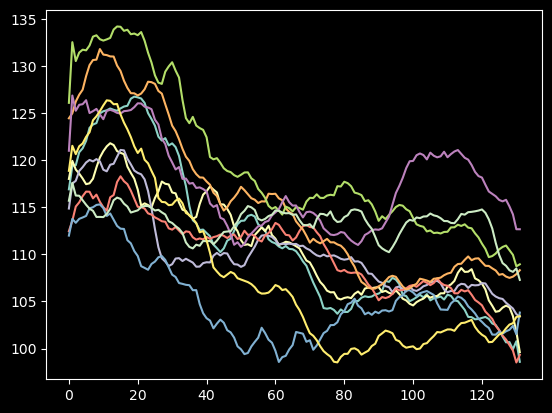

In [71]:
# replace outliers with average of neighbors
smoothed_areas=areas.copy()
for stack_areas in smoothed_areas:
    for i in range(1,len(stack_areas)-1):
        if stack_areas[i]/stack_areas[i-1]>1.1 or stack_areas[i]/stack_areas[i-1]<0.9:
            stack_areas[i]=(stack_areas[i-1]+stack_areas[i+1])/2

# 1D smoothing
smoothed_areas=np.array([np.convolve(stack_areas, np.ones(5)/5, mode='same') for stack_areas in smoothed_areas])

# preserve boundary values
smoothed_areas[:,:2]=areas[:,:2]
smoothed_areas[:,-2:]=areas[:,-2:]

for stack_areas in smoothed_areas:
    plt.plot(stack_areas)

In [7]:
def get_PIP_geminin(stack_location):
    filepath=Path(stack_location.replace('Segmentation','Data'))

    stage_name=filepath.stem.split('-')[-1]
    img_folder=filepath.parents[1]
    img_path=str(img_folder/('{img_type}-'+stage_name+'.tif'))
    pip=io.imread(img_path.format(img_type='PIP'))
    geminin=io.imread(img_path.format(img_type='geminin'))
    return pip, geminin

In [8]:
# assign pip and geminin data to each frame
for stack in tqdm(stacks):
    pip, geminin=get_PIP_geminin(stack.name)
    for frame, pip_frame, geminin_frame in zip(stack.frames, pip, geminin):
        frame.pip=pip_frame
        frame.geminin=geminin_frame

  0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
from scipy import ndimage
def nuclear_threshold(img, masks, bg_quantile=0.5, nuclear_quantile=0.05):
    ndimage_quantile=lambda x: np.quantile(x, nuclear_quantile)
    fluors=ndimage.labeled_comprehension(img, masks, np.unique(masks)[1:], ndimage_quantile, out_dtype=int, default=0)
    bg_cutoff=np.quantile(img[masks==0], bg_quantile)
    return fluors>bg_cutoff

In [10]:
for stack in tqdm(stacks):
    for frame in tqdm(stack.frames, leave=False):
        is_green=nuclear_threshold(frame.pip, frame.masks)
        is_red=nuclear_threshold(frame.geminin, frame.masks)

        NS=~(is_green|is_red)
        is_orange=is_green&is_red
        is_green[is_orange]=0
        is_red[is_orange]=0

        cell_cycle=np.argmax([NS, is_green, is_red, is_orange], axis=0)
        set_cell_attr(frame, 'cycle_stage', cell_cycle)

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

In [11]:
for stack in tqdm(stacks):
    get_interpretable_FUCCI(stack)

  0%|          | 0/10 [00:00<?, ?it/s]

(-0.5, 1124.5, 1585.5, -0.5)

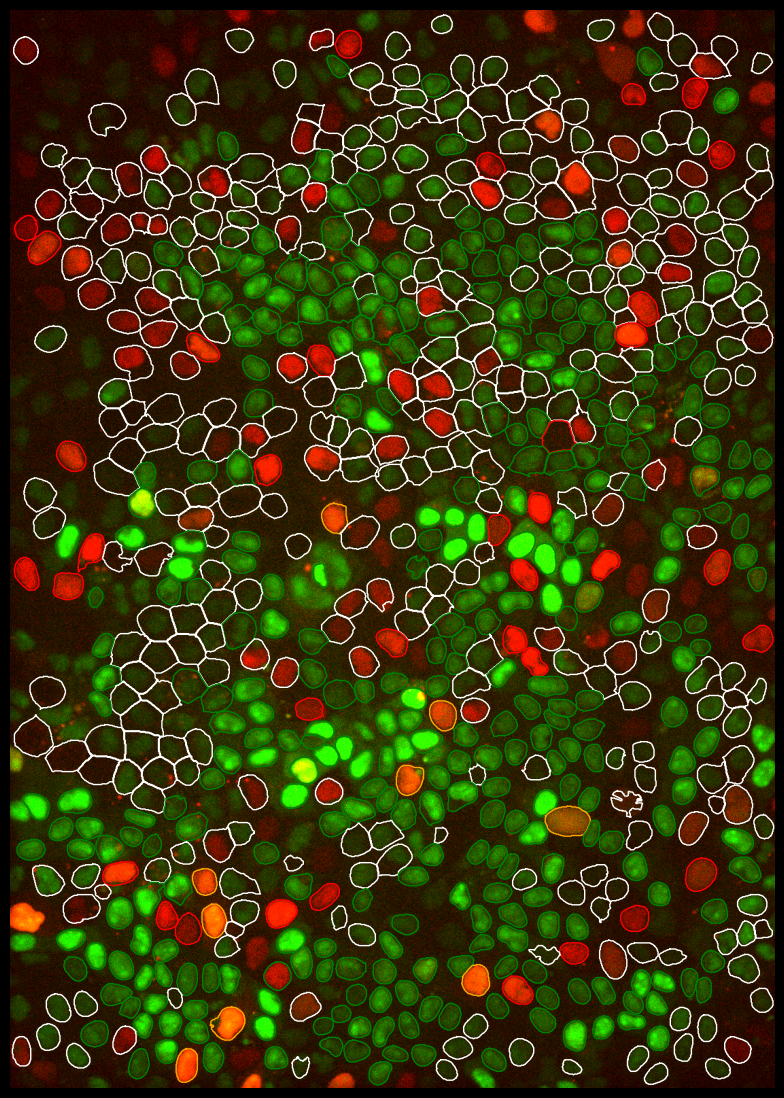

In [45]:
frame=stacks[0].frames[20]
image=np.stack([frame.geminin, frame.pip, np.zeros(frame.pip.shape, dtype=frame.pip.dtype)], axis=-1)
plt.figure(figsize=(10,14))
plt.imshow(preprocessing.normalize(image, quantile=(0.01,0.99)))

for cell in frame.cells:
    if cell.cycle_stage==0:
        color='white'
    elif cell.cycle_stage==1:
        color='green'
    elif cell.cycle_stage==2:
        color='red'
    elif cell.cycle_stage==3:
        color='orange'
    plt.plot(*cell.outline.T, linewidth=1, color=color)

plt.axis('off')

# shape PCA

### get cell contours

In [11]:
# run to resume
from monolayer_tracking import celltool_parallel as ctp
segmented_stages=natsorted(glob('F:/my_data/Segmentation/20240311 FUCCI halo sorted col_glass high_density/segmented_nuclei/*'))

progress=tqdm(segmented_stages[10:])
for stage_dir in progress:
    progress.set_description(Path(stage_dir).stem)
    ctp.export_smoothed_contours(stage_dir, output_path=None, verbose=True, chunk_kwargs=dict(size=16))

  0%|          | 0/9 [00:00<?, ?it/s]

opening F:/my_data/Segmentation/20240311 FUCCI halo sorted col_glass high_density/segmented_nuclei\FUCCI-stage_11
loading contours
created 86597 contours
rescaling contours


  0%|          | 0/5413 [00:00<?, ?it/s]

resampling contours


  0%|          | 0/5413 [00:00<?, ?it/s]

exporting contours
completed F:/my_data/Segmentation/20240311 FUCCI halo sorted col_glass high_density/contours_nuclei\FUCCI-stage_11
opening F:/my_data/Segmentation/20240311 FUCCI halo sorted col_glass high_density/segmented_nuclei\FUCCI-stage_12
loading contours
created 95966 contours
rescaling contours


  0%|          | 0/5998 [00:00<?, ?it/s]

resampling contours


  0%|          | 0/5998 [00:00<?, ?it/s]

In [8]:
# load pickled smoothed contours
contour_dirs=natsorted(glob('F:/my_data/Segmentation/20240311 FUCCI halo sorted col_glass high_density/contours/*'))
smoothed_contours=pd.read_pickle(contour_dirs[0]+'/smoothed_contours.pkl')
print(len(smoothed_contours))

94419


In [10]:
reference_contour=ctp.sample_reference_contour(smoothed_contours)
for contour_dir in tqdm(contour_dirs):
    print(contour_dir)
    ctp.export_aligned_contours(contour_dir, reference_contour, chunk_kwargs=dict(size=8))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

F:/my_data/Segmentation/20240311 FUCCI halo sorted col_glass high_density/contours\FUCCI-stage_1
loaded 94419 contours
aligning contours


  0%|          | 0/11803 [00:00<?, ?it/s]

exporting contours
F:/my_data/Segmentation/20240311 FUCCI halo sorted col_glass high_density/contours\FUCCI-stage_2
loaded 104273 contours
aligning contours


  0%|          | 0/13035 [00:00<?, ?it/s]

exporting contours
F:/my_data/Segmentation/20240311 FUCCI halo sorted col_glass high_density/contours\FUCCI-stage_3
loaded 91932 contours
aligning contours


  0%|          | 0/11492 [00:00<?, ?it/s]

exporting contours
F:/my_data/Segmentation/20240311 FUCCI halo sorted col_glass high_density/contours\FUCCI-stage_4
loaded 100520 contours
aligning contours


  0%|          | 0/12565 [00:00<?, ?it/s]

exporting contours
F:/my_data/Segmentation/20240311 FUCCI halo sorted col_glass high_density/contours\FUCCI-stage_5
loaded 96376 contours
aligning contours


  0%|          | 0/12047 [00:00<?, ?it/s]

exporting contours
F:/my_data/Segmentation/20240311 FUCCI halo sorted col_glass high_density/contours\FUCCI-stage_6
loaded 103971 contours
aligning contours


  0%|          | 0/12997 [00:00<?, ?it/s]

exporting contours
F:/my_data/Segmentation/20240311 FUCCI halo sorted col_glass high_density/contours\FUCCI-stage_7
loaded 96187 contours
aligning contours


  0%|          | 0/12024 [00:00<?, ?it/s]

exporting contours
F:/my_data/Segmentation/20240311 FUCCI halo sorted col_glass high_density/contours\FUCCI-stage_8
loaded 97523 contours
aligning contours


  0%|          | 0/12191 [00:00<?, ?it/s]

exporting contours
F:/my_data/Segmentation/20240311 FUCCI halo sorted col_glass high_density/contours\FUCCI-stage_9
loaded 102343 contours
aligning contours


  0%|          | 0/12793 [00:00<?, ?it/s]

exporting contours
F:/my_data/Segmentation/20240311 FUCCI halo sorted col_glass high_density/contours\FUCCI-stage_10
loaded 100598 contours
aligning contours


  0%|          | 0/12575 [00:00<?, ?it/s]

exporting contours


### do PCA

In [5]:
stack_paths=natsorted(glob('F:/my_data/Segmentation/20240311 FUCCI halo sorted col_glass high_density/segmented_nuclei/FUCCI-stage_*/'))
stacks=[Stack(stack_path,load_img=True) for stack_path in tqdm(stack_paths[:10])]

  0%|          | 0/10 [00:00<?, ?it/s]

In [12]:
import celltool.simple_interface as ct

for stack in tqdm(stacks):
    contour_dir=stack.name.replace('segmented', 'contours')+'/aligned_contours.pkl'
    t=stack.track_centroids(filter_stubs=False)
    t['cell_cycle']=np.concatenate([fetch_cell_cycle(frame) for frame in stack.frames])
    t['contour']=pd.read_pickle(contour_dir)
    stack.tracked_centroids=t

  0%|          | 0/10 [00:00<?, ?it/s]

In [13]:
contours=np.concatenate([stack.tracked_centroids['contour'] for stack in stacks])

In [50]:
# randomly sample 10000 contours
sampled_contours=contours[np.random.choice(len(contours), size=10000, replace=False)]

In [51]:
variance_explained=0.98
pca_contour, header, rows, norm_header, norm_rows = ct.make_shape_model(sampled_contours, required_variance_explained=variance_explained)
print(len(pca_contour.modes))

9


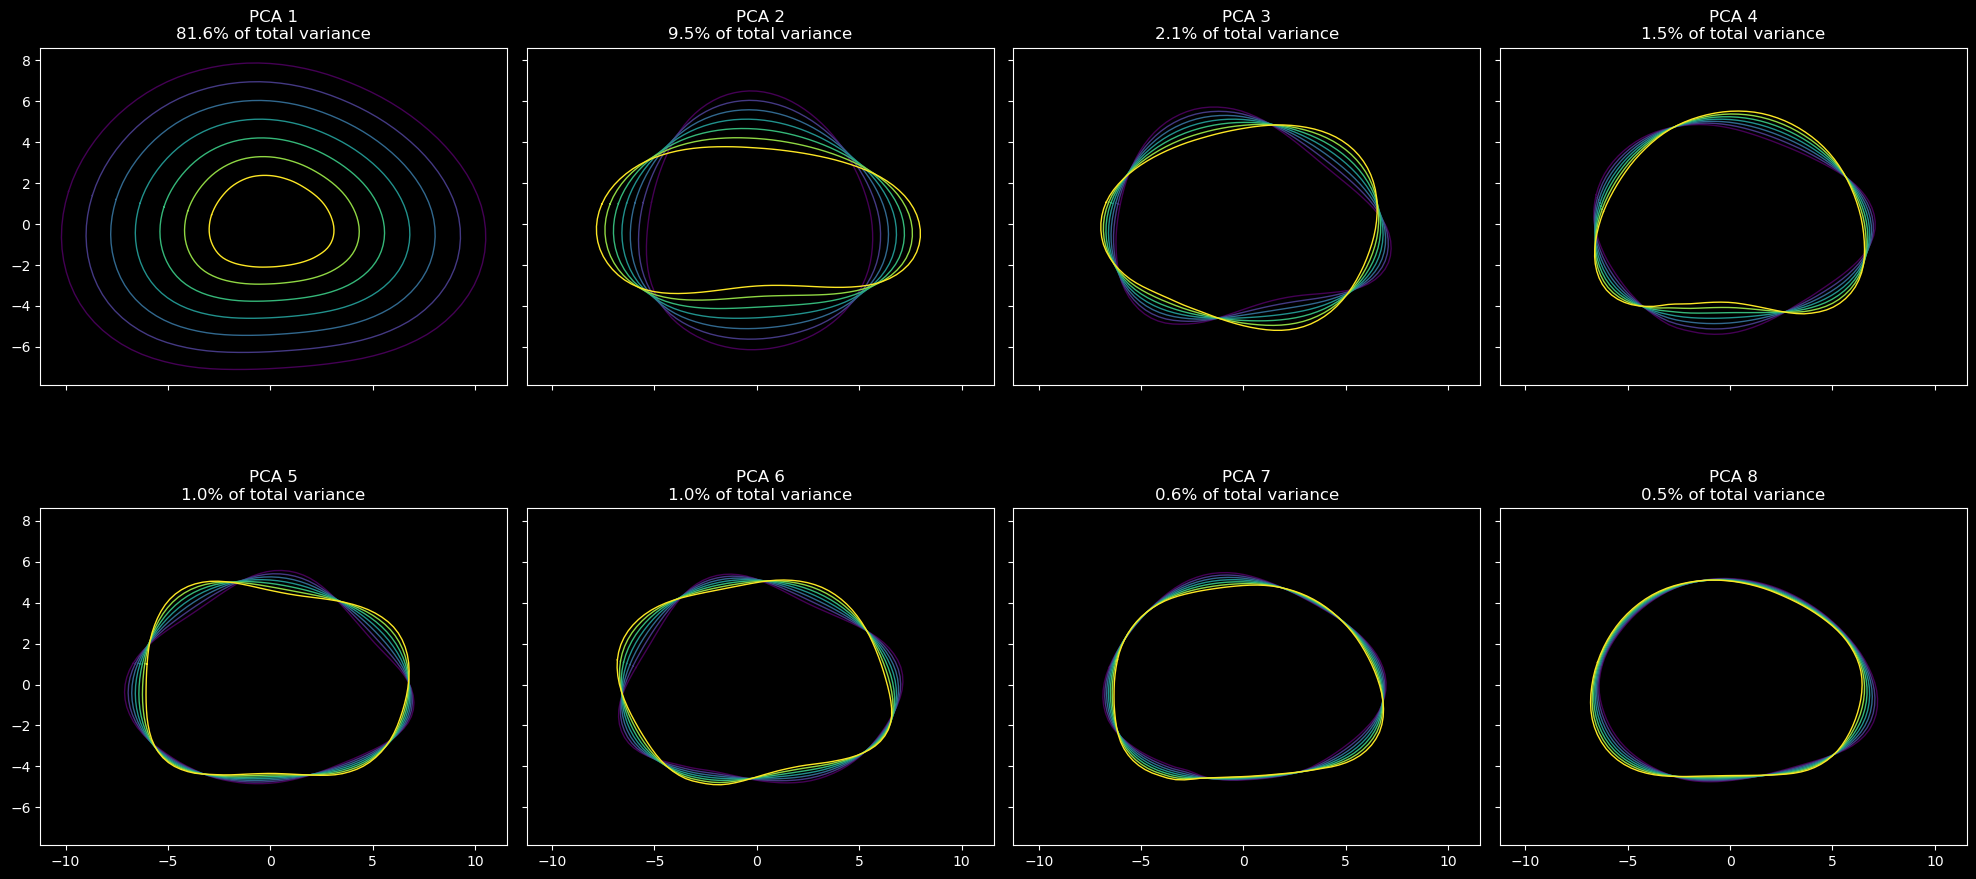

In [52]:
# compute mode stdevs
num_total_modes=len(pca_contour.modes)
modes=np.arange(num_total_modes) # or some subset of the modes which we want to plot

positions = np.array([-3, -2, -1, 0, 1, 2, 3])

mode_contours = []
EVRs = []
for mode in modes:
    inner_contours = []
    for position in positions:
        pos = np.zeros(num_total_modes)
        pos[mode] = position
        inner_contours.append(pca_contour.as_position(pos, normalized = True))
        
    mode_contours.append(inner_contours)
    EVRs.append(pca_contour.standard_deviations[mode]**2/pca_contour.total_variance)
colors = plt.cm.viridis(np.linspace(0, 1, len(positions)))

fig, axes = plt.subplots(2,4, figsize=(20,10), subplot_kw={'aspect':1}, sharex=True, sharey=True)

for n, EVR, mode_contour, ax in zip(modes, EVRs, mode_contours, axes.flatten()):
    for c, color in zip(mode_contour, colors):
        x, y=np.append(c.points, [c.points[0]], axis=0).T
        ax.plot(x, y, color=color, linewidth=1)
    ax.set_title(f'PCA {n+1}\n{EVR*100:.1f}% of total variance')

fig.tight_layout()
plt.show()

In [14]:
shape_model_file='F:/my_data/Segmentation/20240311 FUCCI halo sorted col_glass high_density/contours_nuclei/PCA model.contour'
#pca_contour.to_file(shape_model_file)

# measure all contours with pca contour
measure=ct.ShapeModeMeasurement(shape_model_file, modes=None, normalized=True)
norm_header, norm_rows=ct.measure_contours(contours, False, measure)

In [54]:
normalized_positions=pd.DataFrame(np.array(norm_rows)[:,1:].astype('float'), columns=[f'PCA {n}' for n in range(len(pca_contour.modes))])
normalized_positions.to_csv('C:/Users/Andy/Desktop/FUCCI_nuclei/contours/normalized_positions.csv', index=False)

In [16]:
normalized_positions=pd.DataFrame(np.array(norm_rows)[:,1:].astype('float'), columns=[f'PCA {n}' for n in range(9)])

In [55]:
stack.tracked_centroids

,cell_number,y,x,frame,particle,cell_cycle
0,0,23.281109,695.093488,0,0,2
1,2,26.043434,537.446465,0,1,1
2,3,29.236273,253.250416,0,2,0
3,4,29.424648,342.278169,0,3,0
4,5,29.929607,494.831608,0,4,2
...,...,...,...,...,...,...
100593,450,772.482720,579.831049,131,8157,0
100594,885,1516.200234,620.790357,131,10491,0
100595,871,1486.165604,1091.506005,131,10402,0
100596,786,1341.048697,976.897975,131,10733,0


In [56]:
for n, stack in enumerate(stacks):
    stack.tracked_centroids['stack']=n

In [57]:
t=pd.concat([stack.tracked_centroids for stack in stacks], axis=0, ignore_index=True)

In [58]:
t=pd.concat([t,normalized_positions], axis=1)
t

,cell_number,y,x,frame,particle,cell_cycle,stack,PCA 0,PCA 1,PCA 2,PCA 3,PCA 4,PCA 5,PCA 6,PCA 7,PCA 8
0,0,38.047372,133.901798,0,0,0,0,-3.612533,-2.303457,0.134809,-1.485752,-2.600979,0.923201,-2.449402,-2.718746,-2.579075
1,2,31.436611,534.212121,0,1,2,0,1.011934,-0.649409,-1.291195,-1.191452,-5.997440,0.702256,4.616965,6.293767,1.994870
2,3,28.536325,434.071581,0,2,0,0,-1.308613,-0.938516,-0.046789,0.182078,-0.059769,1.275184,-0.176693,0.067451,-1.357028
3,4,37.895864,388.695716,0,3,0,0,0.343071,-0.799433,-0.866931,1.638862,2.118237,-2.308421,-0.228378,-2.389889,4.964753
4,5,42.418122,949.525655,0,4,0,0,-0.816715,1.285137,-4.677639,0.669278,-4.504084,3.952877,-0.355836,5.911102,1.775953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988137,450,772.482720,579.831049,131,8157,0,9,1.209975,-0.324638,0.510818,0.215223,-0.086400,0.428412,-0.438782,0.739719,-0.118766
988138,885,1516.200234,620.790357,131,10491,0,9,0.163500,0.605786,-0.395913,-0.745371,0.670798,0.189671,1.062235,-0.164016,-0.712186
988139,871,1486.165604,1091.506005,131,10402,0,9,0.976548,0.438087,0.336444,-0.628688,-0.005137,0.104120,-0.669201,-0.463594,-0.174609
988140,786,1341.048697,976.897975,131,10733,0,9,1.911324,-0.502104,-0.201164,-0.371947,0.458678,0.996660,-0.614519,-1.268707,-0.646712


In [59]:
t['unique_particle']=t.groupby(['stack','particle']).ngroup()

,cell_number,y,x,frame,particle,cell_cycle,stack,PCA 0,PCA 1,PCA 2,PCA 3,PCA 4,PCA 5,PCA 6,PCA 7,PCA 8,unique_particle
0,0,38.047372,133.901798,0,0,0,0,-3.612533,-2.303457,0.134809,-1.485752,-2.600979,0.923201,-2.449402,-2.718746,-2.579075,0
1,2,31.436611,534.212121,0,1,2,0,1.011934,-0.649409,-1.291195,-1.191452,-5.997440,0.702256,4.616965,6.293767,1.994870,1
2,3,28.536325,434.071581,0,2,0,0,-1.308613,-0.938516,-0.046789,0.182078,-0.059769,1.275184,-0.176693,0.067451,-1.357028,2
3,4,37.895864,388.695716,0,3,0,0,0.343071,-0.799433,-0.866931,1.638862,2.118237,-2.308421,-0.228378,-2.389889,4.964753,3
4,5,42.418122,949.525655,0,4,0,0,-0.816715,1.285137,-4.677639,0.669278,-4.504084,3.952877,-0.355836,5.911102,1.775953,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988137,450,772.482720,579.831049,131,8157,0,9,1.209975,-0.324638,0.510818,0.215223,-0.086400,0.428412,-0.438782,0.739719,-0.118766,95043
988138,885,1516.200234,620.790357,131,10491,0,9,0.163500,0.605786,-0.395913,-0.745371,0.670798,0.189671,1.062235,-0.164016,-0.712186,97377
988139,871,1486.165604,1091.506005,131,10402,0,9,0.976548,0.438087,0.336444,-0.628688,-0.005137,0.104120,-0.669201,-0.463594,-0.174609,97288
988140,786,1341.048697,976.897975,131,10733,0,9,1.911324,-0.502104,-0.201164,-0.371947,0.458678,0.996660,-0.614519,-1.268707,-0.646712,97619


In [64]:
filtered_t=t[t.groupby('unique_particle').transform('size')>20]
filtered_t=filtered_t[filtered_t.groupby('unique_particle')['cell_cycle'].transform('min')>0].sort_values(['unique_particle','frame'])
filtered_t

,cell_number,y,x,frame,particle,cell_cycle,stack,PCA 0,PCA 1,PCA 2,PCA 3,PCA 4,PCA 5,PCA 6,PCA 7,PCA 8,unique_particle
5,364,761.386653,322.751059,0,5,1,0,-1.996783,1.745602,-0.934556,1.915286,-0.637002,1.776451,4.058415,1.007949,2.742594,5
1074,346,765.641032,318.920436,1,5,1,0,-0.680521,-1.541931,0.619396,-0.577532,0.230409,0.075312,-0.171573,1.824291,-0.418685,5
1767,333,766.332336,317.536818,2,5,1,0,0.302780,-1.177523,0.214337,-0.430231,0.576744,-0.438947,-0.108591,-0.453388,0.207917,5
2463,351,763.104722,318.341892,3,5,1,0,-0.789325,-1.941572,-1.678093,0.376999,0.566983,-2.268928,1.485290,-1.245804,-1.009739,5
3163,326,760.916716,318.295641,4,5,1,0,0.433771,0.799432,-0.565812,1.171704,-2.550200,1.336472,1.344505,0.842678,1.096466,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984553,864,1492.363885,44.769833,127,9184,2,9,1.068694,-1.234497,0.555558,-0.482101,-0.290771,-0.715218,-0.614571,-0.035432,0.625758,96070
985412,859,1491.087775,38.929681,128,9184,2,9,0.764494,1.205352,0.787082,0.329555,-0.702310,-1.313149,-0.246401,-0.163296,0.633697,96070
986313,852,1488.987958,34.289333,129,9184,2,9,-0.030528,0.048904,0.443680,-0.901966,0.330530,-0.229520,-0.123844,-0.029460,0.299361,96070
987212,868,1485.865105,32.194320,130,9184,2,9,-0.807097,1.679609,-0.533751,-1.563798,1.103791,0.320788,0.368057,1.298284,-1.372836,96070


In [53]:
for stack in tqdm(stacks):
    get_interpretable_FUCCI(stack)

  0%|          | 0/10 [00:00<?, ?it/s]

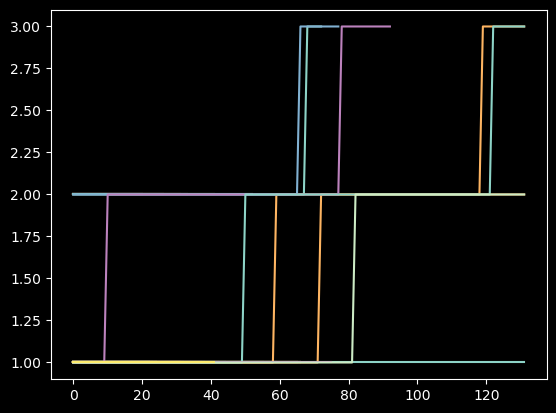

In [67]:
# iterate over the first 10 particles
counter=0
for particle_ID, particle_group in filtered_t.groupby('unique_particle'):
    plt.plot(particle_group['frame'], particle_group['cell_cycle'], label=particle_ID)
    counter+=1
    if counter==40:
        break


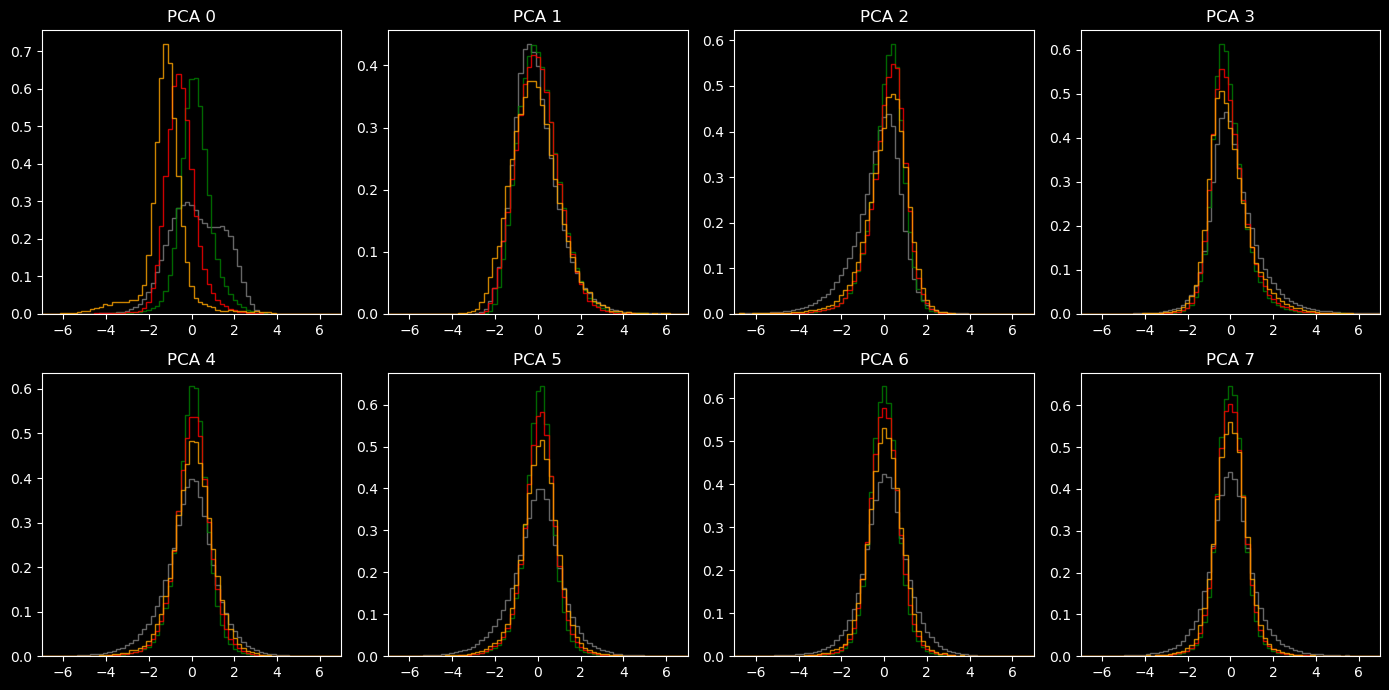

In [57]:
colors=['gray', 'green','red','orange']
fig, axes=plt.subplots(2,4, figsize=(14,7))
for cc_stage, PCA_coords in t.groupby('cell_cycle'):
    for n, ax in zip(range(len(pca_contour.modes)), axes.flatten()):
        ax.hist(PCA_coords[f'PCA {n}'], histtype='step', alpha=0.8, linewidth=1, color=colors[cc_stage], bins=np.linspace(-10,10,100), density=True)

for n, ax in enumerate(axes.flatten()):
    ax.set_title(f'PCA {n}')
    ax.set_xlim(-7,7)


fig.tight_layout()
#plt.savefig('plots/cell_cycle_shape_PCA-moderate.jpg', dpi=300)

### export training data for tensorflow

In [82]:
t['frame_area']=np.concatenate(frame_areas)

In [84]:
t.to_csv(PCA_export_location, index=False)

In [78]:
# assign area value for the frame to each cell in that frame
for stack, a in zip(tqdm(stacks), smoothed_areas):
    for frame, mean_area in zip(stack.frames, a):
        set_cell_attr(frame, 'mean_area', np.ones(len(frame.cells))*mean_area)

  0%|          | 0/10 [00:00<?, ?it/s]

In [79]:
# get density for each cell in each frame
frame_areas=[]
for stack in tqdm(stacks):
    for frame in stack.frames:
        frame_areas.append(get_cell_attr(frame, 'mean_area'))

  0%|          | 0/10 [00:00<?, ?it/s]

In [80]:
np.concatenate(frame_areas).shape

(988142,)

In [68]:
PCA_cc['frame_area']=np.concatenate(frame_areas)

In [3]:
PCA_export_location='F:/my_data/Segmentation/20240311 FUCCI halo sorted col_glass high_density/contours_nuclei/PCA_training.csv'
contour_export_location='F:/my_data/Segmentation/20240311 FUCCI halo sorted col_glass high_density/contours_nuclei/contours.pkl'

In [58]:
# export PCA training and contours
t[[f'PCA {n}' for n in range(8)]+['cell_cycle']].to_csv(PCA_export_location, index=False)
pd.to_pickle(t['contour'], contour_export_location)

# cell cycle MLP

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.style.use('dark_background')

In [4]:
PCA_cc=pd.read_csv(PCA_export_location)
contours=pd.read_pickle(contour_export_location)

### over time

In [14]:
filtered_data=PCA_cc[PCA_cc.groupby('unique_particle')['cell_cycle'].transform('min')>0]
filtered_data=filtered_data[filtered_data.groupby('unique_particle').transform('size')>20]

In [15]:
# smooth PCA data for each unique particle
# 1D smoothing function
def smooth_PCA(x):
    smooth=np.convolve(x, np.ones(5)/5, mode='same')
    # preserve boundary values
    smooth[:2]=x[:2]
    smooth[-2:]=x[-2:]
    return smooth

smoothed_PCA=filtered_data.groupby('unique_particle')[[f'PCA {n}' for n in range(8)]].transform(smooth_PCA)

In [16]:
filtered_data[[f'PCA {n}' for n in range(8)]]=smoothed_PCA

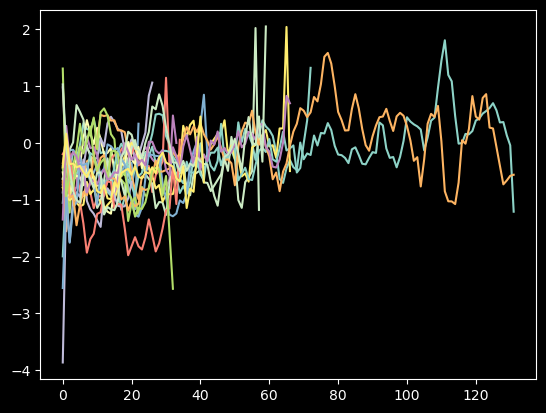

In [17]:
counter=0
for particle_ID, particle_group in filtered_data.groupby('unique_particle'):
    plt.plot(particle_group['frame'], particle_group['PCA 0'], label=particle_ID)
    counter+=1
    if counter==20:
        break

In [18]:
# randomly slice 10 consecutive values from each unique particle
n=15
sliced_data=filtered_data.groupby('unique_particle', group_keys=False).apply(lambda g: g.iloc[(x:=np.random.randint(0, len(g)-n)): x+n])

In [19]:
n_particles=int(len(sliced_data)/n)
n_particles

10332

In [20]:
y=sliced_data['cell_cycle']
X=sliced_data.drop(['cell_number','particle','unique_particle','cell_cycle']+[f'PCA {n}' for n in range(8)], axis=1)

In [21]:
y

43775     1
44460     1
45138     1
45829     1
46518     1
         ..
981902    2
982824    2
983681    2
984553    2
985412    2
Name: cell_cycle, Length: 154980, dtype: int64

In [102]:
y_onehot=pd.get_dummies(y)

In [22]:
# standard scale PCA coordinates
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

X_scaled=scaler.fit_transform(X)

In [23]:
X_scaled=np.array(np.split(X_scaled, n_particles))
y=np.array(np.split(y.to_numpy(), n_particles))
#y_onehot=np.array(np.split(y_onehot.to_numpy(), n_particles))

In [27]:
y_transitions=np.diff(y, axis=1)

In [30]:
np.unique(y_transitions, return_counts=True)

(array([0, 1], dtype=int64), array([144010,    638], dtype=int64))

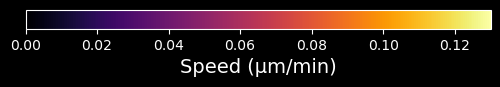

In [38]:
# draw a fake colorbar with inferno colormap
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(6, 0.5))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.inferno
norm = mpl.colors.Normalize(vmin=0, vmax=0.13)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Speed (μm/min)', fontsize=14)

plt.show()

In [108]:
def get_transitions(cell_cycle):
    is_transition=[True,*(np.diff(cell_cycle)!=0)]
    stages=cell_cycle[is_transition]
    stage_lengths=np.diff(np.where(is_transition)[0])
    padding=3-len(stages)
    if padding>0:
        stages=np.pad(stages, (0,padding), constant_values=-1)
    return stages

transition_types=np.array([[ 1, -1, -1],
        [ 1,  2, -1],
        [ 2, -1, -1],
        [ 2,  3, -1],
        [ 3, -1, -1]])

transition_class=[]
for cell_y in tqdm(y):
    transition_class.append(np.where(np.all(transition_types==get_transitions(cell_y), axis=1))[0][0])

  0%|          | 0/10332 [00:00<?, ?it/s]

In [94]:
class_weights=len(transition_class)/np.unique(transition_class, return_counts=True)[1]

# create class weights dict
class_weight_dict={i:w for i,w in enumerate(class_weights)}

In [109]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.2, stratify=transition_class)

In [111]:
y_train.shape

(8265, 15, 3)

In [160]:
# create a simple neural network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

def DenseDropout(layer_size, activation, drop_rate, kernel_constraint, name):
    x=Sequential([layers.Dense(layer_size, activation=activation, kernel_constraint=kernel_constraint), layers.Dropout(drop_rate)], name=name)
    return x

model=keras.Sequential([
    layers.Input(shape=(X_train.shape[1:])),
    layers.Flatten(),
    DenseDropout(64, 'relu', 0.7, None, 'dense1'),
    DenseDropout(64, 'relu', 0.7, None, 'dense2'),
    layers.Dense(45, activation=None),
    layers.Reshape((15,3)),
    layers.Softmax(),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 210)               0         
                                                                 
 dense1 (Sequential)         (None, 64)                13504     
                                                                 
 dense2 (Sequential)         (None, 64)                4160      
                                                                 
 dense_46 (Dense)            (None, 45)                2925      
                                                                 
 reshape_12 (Reshape)        (None, 15, 3)             0         
                                                                 
 softmax_12 (Softmax)        (None, 15, 3)             0         
                                                                 
Total params: 20,589
Trainable params: 20,589
Non-tra

In [161]:
history=model.fit(X_train, y_train, shuffle=True, validation_split=0.2, epochs=1000, batch_size=2048)

Epoch 1/1000
7/7 [==============================] - 1s 31ms/step - loss: 2.0165 - accuracy: 0.3251 - val_loss: 1.1311 - val_accuracy: 0.3680
Epoch 2/1000
7/7 [==============================] - 0s 9ms/step - loss: 1.5888 - accuracy: 0.3631 - val_loss: 1.0495 - val_accuracy: 0.4486
Epoch 3/1000
7/7 [==============================] - 0s 11ms/step - loss: 1.3455 - accuracy: 0.4005 - val_loss: 1.0129 - val_accuracy: 0.5202
Epoch 4/1000
7/7 [==============================] - 0s 17ms/step - loss: 1.2055 - accuracy: 0.4286 - val_loss: 0.9916 - val_accuracy: 0.5724
Epoch 5/1000
7/7 [==============================] - 0s 8ms/step - loss: 1.1219 - accuracy: 0.4543 - val_loss: 0.9749 - val_accuracy: 0.6059
Epoch 6/1000
7/7 [==============================] - 0s 14ms/step - loss: 1.0611 - accuracy: 0.4803 - val_loss: 0.9571 - val_accuracy: 0.6254
Epoch 7/1000
7/7 [==============================] - 0s 12ms/step - loss: 1.0199 - accuracy: 0.5053 - val_loss: 0.9363 - val_accuracy: 0.6354
Epoch 8/1000
7/

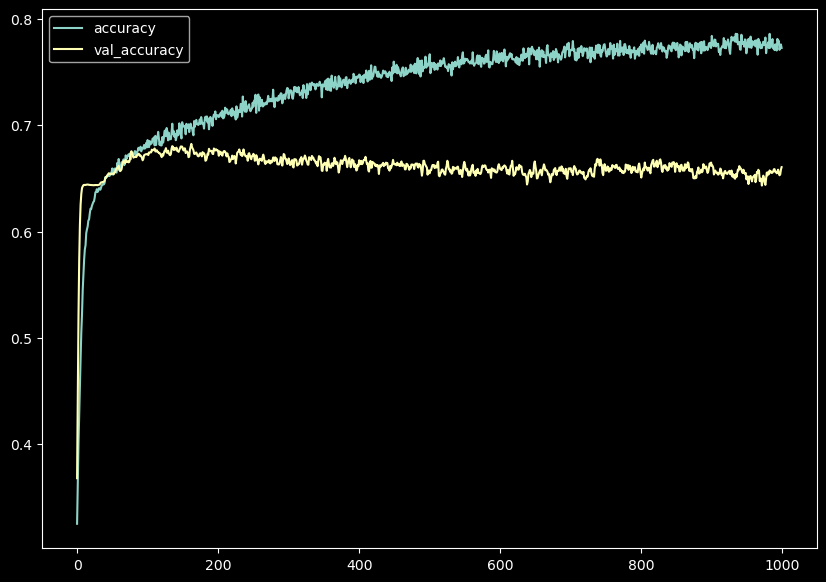

In [162]:
# plot training history
plt.figure(figsize=(10,7))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [169]:
# evaluate model

from sklearn.metrics import classification_report, confusion_matrix
y_pred=model.predict(X_test)

 1/65 [..............................] - ETA: 0s

65/65 [==============================] - 0s 3ms/step


In [170]:
np.unique([get_transitions(cell_y)[:3] for cell_y in y_pred.argmax(axis=-1)+1], axis=0, return_counts=True)

(array([[ 1, -1, -1],
        [ 1,  2, -1],
        [ 1,  2,  1],
        [ 2, -1, -1],
        [ 2,  1, -1],
        [ 2,  1,  2]], dtype=int64),
 array([1640,    3,    2,  402,   17,    3], dtype=int64))

In [172]:
np.unique([get_transitions(cell_y)[:3] for cell_y in y_train.argmax(axis=-1)+1], axis=0, return_counts=True)

(array([[ 1, -1, -1],
        [ 1,  2, -1],
        [ 2, -1, -1],
        [ 2,  3, -1],
        [ 3, -1, -1]], dtype=int64),
 array([5252,  169, 2319,  321,  204], dtype=int64))

In [138]:
y_pred=model.predict(X_test)


65/65 [==============================] - 0s 3ms/step


### linear model

In [13]:
X_signal=X_scaled.loc[~y[0]]
y_signal=y.loc[~y[0]]
y_signal=y_signal.iloc[:,1:].astype(int)

In [6]:
X=PCA_cc.drop(columns='cell_cycle')
# normalize frame_area
X['frame_area']=(X['frame_area']-X['frame_area'].mean())/X['frame_area'].std()
# one-hot encode cell cycle
y=pd.get_dummies(PCA_cc['cell_cycle'])
# only select rows with fluorescent info
X_signal=X.loc[~y[0]]
y_signal=y.loc[~y[0]]
y_signal=y_signal.iloc[:,1:].astype(int)

In [60]:
y_signal

,1,2,3
6,0,1,0
12,1,0,0
14,0,1,0
20,1,0,0
25,0,1,0
...,...,...,...
988136,1,0,0
988138,0,1,0
988139,0,1,0
988140,1,0,0


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_signal, y_signal, test_size=0.2, stratify=y_signal)

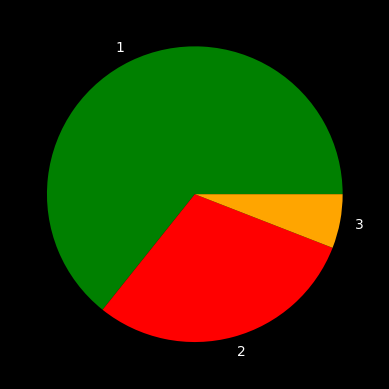

In [9]:
# observe that the data is imbalanced
plt.pie(np.sum(y_train, axis=0), labels=y_train.columns, colors=['green', 'red', 'orange'])
plt.show()

In [10]:
class_weights=np.array(len(y_train)/np.sum(y_train, axis=0))
class_weights_dict=dict()
for n, weight in enumerate(class_weights):
    class_weights_dict[n]=weight

In [12]:
# simple linear classifier with keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from tensorflow.keras import callbacks

linear_model=keras.Sequential([
    layers.Dense(3, activation='softmax', input_shape=X_train.shape[1:], kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01), kernel_initializer=initializers.he_normal()),
])

linear_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping=callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history=linear_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=4096, class_weight=class_weights_dict, callbacks=[early_stopping])

Epoch 1/100
271/271 [==============================] - 2s 3ms/step - loss: 5.0992 - accuracy: 0.2021 - val_loss: 1.5131 - val_accuracy: 0.2130
Epoch 2/100
271/271 [==============================] - 1s 3ms/step - loss: 3.9332 - accuracy: 0.2327 - val_loss: 1.2778 - val_accuracy: 0.2708
Epoch 3/100
271/271 [==============================] - 1s 3ms/step - loss: 3.3350 - accuracy: 0.3833 - val_loss: 1.0972 - val_accuracy: 0.5215
Epoch 4/100
271/271 [==============================] - 1s 3ms/step - loss: 3.0222 - accuracy: 0.5696 - val_loss: 0.9937 - val_accuracy: 0.5882
Epoch 5/100
271/271 [==============================] - 1s 3ms/step - loss: 2.8507 - accuracy: 0.5991 - val_loss: 0.9342 - val_accuracy: 0.6084
Epoch 6/100
271/271 [==============================] - 1s 3ms/step - loss: 2.7480 - accuracy: 0.6173 - val_loss: 0.8997 - val_accuracy: 0.6237
Epoch 7/100
271/271 [==============================] - 1s 3ms/step - loss: 2.6822 - accuracy: 0.6286 - val_loss: 0.8764 - val_accuracy: 0.6361

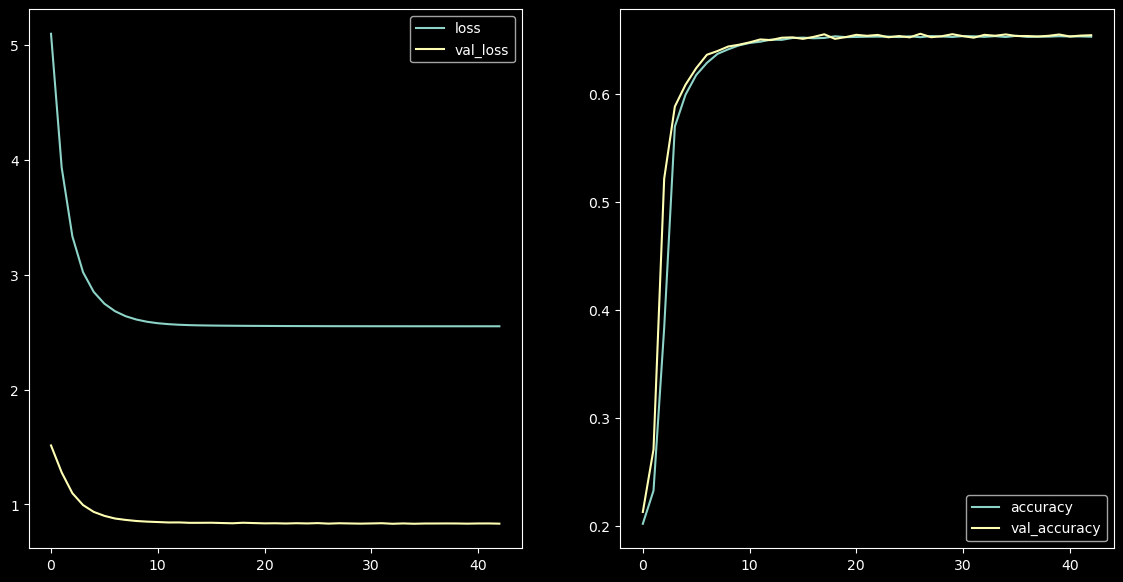

In [13]:
# evaluate model
fig, axes=plt.subplots(1,2, figsize=(14,7))
axes[0].plot(history.history['loss'], label='loss')
axes[0].plot(history.history['val_loss'], label='val_loss')

axes[1].plot(history.history['accuracy'], label='accuracy')
axes[1].plot(history.history['val_accuracy'], label='val_accuracy')

for ax in axes:
    ax.legend()

plt.show()

 1/33 [..............................] - ETA: 0s

33/33 [==============================] - 0s 3ms/step


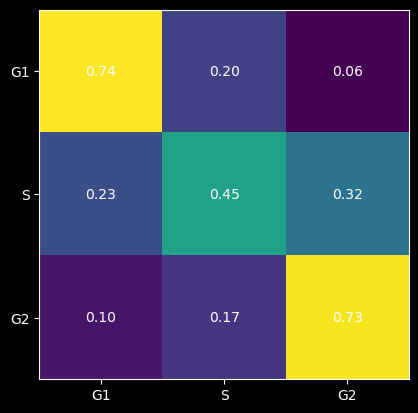

In [15]:
# confusion matrix
from sklearn.metrics import confusion_matrix
y_pred=linear_model.predict(X_test, batch_size=4096)
y_pred=np.argmax(y_pred, axis=1)
y_true=np.argmax(y_test.to_numpy(), axis=1)

# plot confusion matrix with imshow
cm=confusion_matrix(y_true, y_pred, normalize='true')
fig, ax=plt.subplots()
im=ax.imshow(cm)

# label boxes with counts
for i in range(3):
    for j in range(3):
        ax.text(j, i, f'{cm[i, j]:.2f}', ha='center', va='center', color='white')

# label axes with cell cycle stages
ax.set_xticks(range(3), ['G1', 'S', 'G2'])
ax.set_yticks(range(3), ['G1', 'S', 'G2'])

([<matplotlib.axis.YTick at 0x14036af9c10>,
 [Text(0, 0, 'G1'), Text(0, 1, 'S'), Text(0, 2, 'G2')])

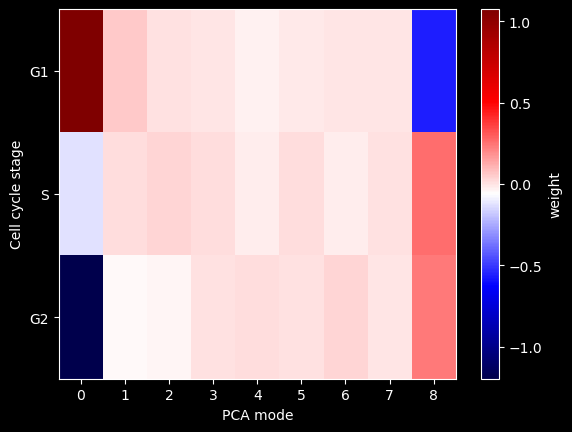

In [16]:
plt.imshow(linear_model.weights[0].numpy().T, cmap='seismic', aspect='auto')
plt.colorbar(label='weight')
plt.xlabel('PCA mode')
plt.ylabel('Cell cycle stage')

plt.yticks(range(3), ['G1', 'S', 'G2'])

2/2 [==============================] - 0s 0s/step


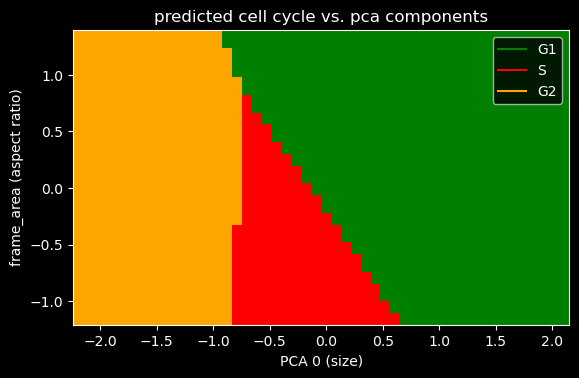

In [58]:
resolution=50
component_a='PCA 0'
component_b='frame_area'
a_index=X_signal.columns.get_loc(component_a)
b_index=X_signal.columns.get_loc(component_b)

pca_a_quantile=np.quantile(X_signal[component_a], [0.01, 0.99])
pca_b_quantile=np.quantile(X_signal[component_b], [0.01, 0.99])
pca_a=np.linspace(*pca_a_quantile, resolution)
pca_b=np.linspace(*pca_b_quantile, resolution)
pca_grid_a, pca_grid_b=np.meshgrid(pca_a, pca_b)

# run the model on each point in the grid
pca_vectors=np.zeros((pca_grid_a.size, len(X_signal.columns)))
pca_vectors[:,a_index]=pca_grid_a.flatten()
pca_vectors[:,b_index]=pca_grid_b.flatten()

# run the model
phase_space=linear_model.predict(pca_vectors, batch_size=2048).reshape(resolution,resolution,3)

# create a fake colormap to match the colors of the cell cycle
from matplotlib.colors import ListedColormap
cmap=ListedColormap(['green', 'red', 'orange'])

plt.imshow(np.argmax(phase_space, axis=-1), cmap=cmap, extent=[*pca_a_quantile, *pca_b_quantile])

# add a fake legend labeling G1, S, G2
plt.plot([0,0],[0,0], color='green', label='G1')
plt.plot([0,0],[0,0], color='red', label='S')
plt.plot([0,0],[0,0], color='orange', label='G2')

plt.xlabel(f'{component_a} (size)')
plt.ylabel(f'{component_b} (aspect ratio)')
plt.title('predicted cell cycle vs. pca components')
plt.legend()

In [71]:
binary_ytrain=y_train.copy()
binary_ytrain[2]=binary_ytrain[2]+binary_ytrain[3]
binary_ytrain.drop(3, axis=1, inplace=True)

binary_ytest=y_test.copy()
binary_ytest[2]=binary_ytest[2]+binary_ytest[3]
binary_ytest.drop(3, axis=1, inplace=True)

### deep MLP

In [66]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import MaxNorm

def DenseDropout(layer_size, activation, drop_rate, kernel_constraint, name):
    x=Sequential([layers.Dense(layer_size, activation=activation, kernel_constraint=kernel_constraint), layers.Dropout(drop_rate)], name=name)
    return x

n_layers=10
layer_size=10

model = Sequential([#norm_layer,
    layers.Flatten(input_shape=X_train.shape[1:]),
    *[DenseDropout(layer_size, drop_rate=0.2, activation='relu', kernel_constraint=MaxNorm(3), name=f'DenseDropoput_{layer}') for layer in range(n_layers)],
    layers.Dense(binary_ytrain.shape[-1]), # use_bias=False
    layers.Softmax()
])

optimizer = Adam(learning_rate=0.1) # optimizer: SGD, Adam
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])#, metrics=["RootMeanSquaredError"])
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 9)                 0         
                                                                 
 DenseDropoput_0 (Sequential  (None, 10)               100       
 )                                                               
                                                                 
 DenseDropoput_1 (Sequential  (None, 10)               110       
 )                                                               
                                                                 
 DenseDropoput_2 (Sequential  (None, 10)               110       
 )                                                               
                                                                 
 DenseDropoput_3 (Sequential  (None, 10)               110       
 )                                                   

In [67]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_path=Path('tf_checkpoints/nuclear_FUCCI_checkpoints/20240314_binary/weights.{epoch:04d}-{val_accuracy:.4f}.hdf5')
checkpoint_path.parent.mkdir(parents=True, exist_ok=True)

checkpoint_cb=ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=True)

# early stopping
early_stopping_cb=callbacks.EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)

In [73]:
from keras.optimizers import Adagrad, Adam
optimizer = Adam(learning_rate=0.001) # optimizer: SGD, Adam
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])#, metrics=["RootMeanSquaredError"])

In [74]:
history = model.fit(X_train, binary_ytrain,
                    epochs=20000, initial_epoch=0,
                    validation_split=0.2,
                    callbacks=[checkpoint_cb, early_stopping_cb],
                    batch_size=4096,
                    class_weight=class_weights_dict
                    )

Epoch 1/20000
106/106 [==============================] - 2s 10ms/step - loss: 1.4800 - accuracy: 0.4184 - val_loss: 0.6584 - val_accuracy: 0.7295
Epoch 2/20000
106/106 [==============================] - 1s 8ms/step - loss: 1.3658 - accuracy: 0.7016 - val_loss: 0.6084 - val_accuracy: 0.7817
Epoch 3/20000
106/106 [==============================] - 1s 7ms/step - loss: 1.2866 - accuracy: 0.7432 - val_loss: 0.5816 - val_accuracy: 0.7795
Epoch 4/20000
106/106 [==============================] - 1s 8ms/step - loss: 1.2394 - accuracy: 0.7552 - val_loss: 0.5590 - val_accuracy: 0.7854
Epoch 5/20000
106/106 [==============================] - 1s 8ms/step - loss: 1.2113 - accuracy: 0.7577 - val_loss: 0.5487 - val_accuracy: 0.7869
Epoch 6/20000
106/106 [==============================] - 1s 7ms/step - loss: 1.1950 - accuracy: 0.7581 - val_loss: 0.5395 - val_accuracy: 0.7863
Epoch 7/20000
106/106 [==============================] - 1s 8ms/step - loss: 1.1826 - accuracy: 0.7581 - val_loss: 0.5322 - val_a

In [62]:
model.load_weights('tf_checkpoints/nuclear_FUCCI_checkpoints/20240314/weights.0135-0.6805.hdf5')

In [75]:
prediction=model.predict(X_test, batch_size=4096)

33/33 [==============================] - 0s 3ms/step


In [78]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(np.argmax(binary_ytest.values, axis=1), np.argmax(prediction, axis=1)))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85     86853
           1       0.77      0.58      0.67     48263

    accuracy                           0.79    135116
   macro avg       0.78      0.74      0.76    135116
weighted avg       0.79      0.79      0.78    135116



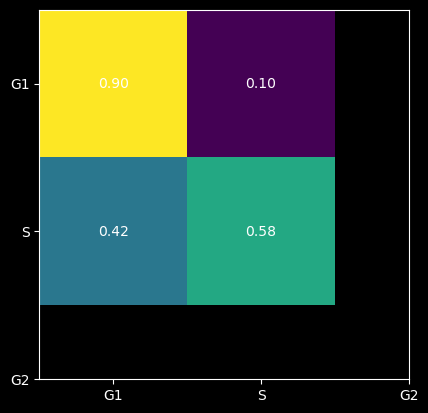

In [80]:
conf_mat=confusion_matrix(np.argmax(binary_ytest.values, axis=1), np.argmax(prediction, axis=1), normalize='true')
plt.imshow(conf_mat, cmap='viridis')
plt.xticks([0,1,2],['G1','S','G2'])
plt.yticks([0,1,2],['G1','S','G2'])
# write numerical values on the heatmap
for i in range(2):
    for j in range(2):
        plt.text(j, i, f'{conf_mat[i, j]:.2f}', ha='center', va='center', color='white')

In [34]:
X_signal

,PCA 0,PCA 1,PCA 2,PCA 3,PCA 4,PCA 5,PCA 6,PCA 7,frame_area
6,-0.738087,-0.158507,1.585245,-0.091336,-0.364018,0.049836,-0.564199,0.580075,-0.163144
12,-0.116707,-0.446111,0.693286,-0.267126,0.708887,1.084133,-0.343651,0.251412,-0.163144
14,-0.921221,0.038049,0.905177,-0.425166,-1.945451,2.706159,0.960994,-0.122849,-0.163144
20,1.057335,1.099850,0.469185,0.715872,-0.392496,-1.028420,-1.851462,1.627648,-0.163144
25,-0.405482,0.929782,-1.591254,1.638211,0.447399,0.933678,0.641308,0.975521,-0.163144
...,...,...,...,...,...,...,...,...,...
988136,0.764062,-1.242076,0.718478,0.102230,0.875566,0.394652,0.643242,0.050119,1.113549
988138,0.163500,0.605786,-0.395913,-0.745371,0.670798,0.189671,1.062235,-0.164016,1.113549
988139,0.976548,0.438087,0.336444,-0.628688,-0.005137,0.104120,-0.669201,-0.463594,1.113549
988140,1.911324,-0.502104,-0.201164,-0.371947,0.458678,0.996660,-0.614519,-1.268707,1.113549


In [50]:
X_signal.columns.get_loc(component_a)

0

In [81]:
resolution=50
component_a='PCA 0'
component_b='frame_area'
a_index=X_signal.columns.get_loc(component_a)
b_index=X_signal.columns.get_loc(component_b)

pca_a_quantile=np.quantile(X_signal[component_a], [0.01, 0.99])
pca_b_quantile=np.quantile(X_signal[component_b], [0.01, 0.99])
pca_a=np.linspace(*pca_a_quantile, resolution)
pca_b=np.linspace(*pca_b_quantile, resolution)
pca_grid_a, pca_grid_b=np.meshgrid(pca_a, pca_b)

# run the model on each point in the grid
pca_vectors=np.zeros((pca_grid_a.size, len(X_signal.columns)))
pca_vectors[:,a_index]=pca_grid_a.flatten()
pca_vectors[:,b_index]=pca_grid_b.flatten()

# run the model
phase_space=model.predict(pca_vectors, batch_size=2048).reshape(resolution,resolution,3)

# create a fake colormap to match the colors of the cell cycle
from matplotlib.colors import ListedColormap
cmap=ListedColormap(['green', 'red', 'orange'])

plt.imshow(np.argmax(phase_space, axis=-1), cmap=cmap, extent=[*pca_a_quantile, *pca_b_quantile])

# add a fake legend labeling G1, S, G2
plt.plot([0,0],[0,0], color='green', label='G1')
plt.plot([0,0],[0,0], color='red', label='S')
plt.plot([0,0],[0,0], color='orange', label='G2')

plt.xlabel(f'{component_a} (size)')
plt.ylabel(f'{component_b} (aspect ratio)')
plt.title('predicted cell cycle vs. pca components')
plt.legend()

2/2 [==============================] - 0s 39ms/step


ValueError: cannot reshape array of size 5000 into shape (50,50,3)